In [3]:
import pandas as pd
import transformers 
import numpy as np
import torch
from collections import OrderedDict 

import sys

sys.path.insert(0, '..')

from decompose_gpt2 import GPT2ForSequenceClassificationDecomposed, GPT2Config
from analysis.preprocess_input import split_pos_neg_contributions

import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
labels = ['awareness', 'change_of_location', 'change_of_state',
       'change_of_possession', 'existed_after', 'existed_before',
       'existed_during', 'instigation', 'sentient', 'volition']
# labels = ['awareness',
#        'change_of_location', 'change_of_state', 'changes_possession',
#        'created', 'destroyed', 'existed_after', 'existed_before',
#        'existed_during', 'exists_as_physical', 'instigation',
#        'location_of_event', 'makes_physical_contact', 'manipulated_by_another',
#        'predicate_changed_argument', 'sentient', 'stationary', 'volition']


In [5]:

path = "../../combined_SPRL_gpt2"
model = transformers.AutoModelForSequenceClassification.from_pretrained(path)

new_state_dict = OrderedDict()
for key, value in model.state_dict().items():
    # ref : https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html
    new_key = key.replace("ln_1.weight", "ln_1.gamma").replace("ln_1.bias", "ln_1.beta")
    new_key = new_key.replace("ln_2.weight", "ln_2.gamma").replace("ln_2.bias", "ln_2.beta")
    new_key = new_key.replace("ln_f.weight", "ln_f.gamma").replace("ln_f.bias", "ln_f.beta")
    new_state_dict[new_key] = value


In [6]:
decomposed_model = GPT2ForSequenceClassificationDecomposed(
    config= GPT2Config.from_dict(model.config.to_dict()),
    debug=False, 
    num_labels=len(labels) * 3
    )

tokenizer = transformers.AutoTokenizer.from_pretrained(path + "/tokenizer")
decomposed_model.model.load_state_dict(new_state_dict)
decomposed_model.model.eval()


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x Block(
        (ln_1): LayerNorm((1024,), eps=1e-05)
        (attn): Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05)
        (mlp): MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05)
  )
  (score): Linear(in_features=1024, out_features=30, bias=False)
)

In [30]:
model = decomposed_model.model

verb = ["<p>", "followed"]
arg = ["<a>", "The", "police", "dog"]
encoded_input = tokenizer("<a>The police dog<a> tirelessly<p> followed<p> the ruthless criminal using his scent.", return_tensors='pt')
# verb = ["<p>", "followed"]
# arg = ["<a>", "the", "ruthless", "criminal"]
# encoded_input = tokenizer("The police dog tirelessly<p> followed<p><a> the ruthless criminal<a> using his scent.", return_tensors='pt')

text = list(map(lambda x: x.strip("Ġ"), tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0])))
print(text)

with torch.no_grad():
    logits = model(**encoded_input)["logits"]
    logits = torch.Tensor(logits.reshape(logits.shape[0], 3, len(labels)))

    # get probabilities using softmax
    probs = torch.softmax(logits, axis=1).squeeze()
    y_pred = torch.argmax(probs, axis=0)
for l, y, p in zip(labels, y_pred, probs.T):
    print(l, y.item(), p)

probs


['<a>', 'The', 'police', 'dog', '<a>', 'tirelessly', '<p>', 'followed', '<p>', 'the', 'ruthless', 'criminal', 'using', 'his', 'scent', '.']
awareness 2 tensor([1.4029e-04, 1.6199e-05, 9.9984e-01], dtype=torch.float64)
change_of_location 2 tensor([1.3396e-04, 2.1003e-04, 9.9966e-01], dtype=torch.float64)
change_of_state 1 tensor([0.3001, 0.4871, 0.2128], dtype=torch.float64)
change_of_possession 0 tensor([0.9969, 0.0014, 0.0017], dtype=torch.float64)
existed_after 2 tensor([2.2288e-04, 8.2694e-04, 9.9895e-01], dtype=torch.float64)
existed_before 2 tensor([5.0662e-07, 2.0484e-07, 1.0000e+00], dtype=torch.float64)
existed_during 2 tensor([1.2624e-08, 2.3389e-09, 1.0000e+00], dtype=torch.float64)
instigation 2 tensor([3.2157e-04, 8.5407e-05, 9.9959e-01], dtype=torch.float64)
sentient 2 tensor([1.3324e-05, 4.9706e-06, 9.9998e-01], dtype=torch.float64)
volition 2 tensor([2.9063e-03, 1.5078e-04, 9.9694e-01], dtype=torch.float64)


tensor([[1.4029e-04, 1.3396e-04, 3.0013e-01, 9.9691e-01, 2.2288e-04, 5.0662e-07,
         1.2624e-08, 3.2157e-04, 1.3324e-05, 2.9063e-03],
        [1.6199e-05, 2.1003e-04, 4.8712e-01, 1.4353e-03, 8.2694e-04, 2.0484e-07,
         2.3389e-09, 8.5407e-05, 4.9706e-06, 1.5078e-04],
        [9.9984e-01, 9.9966e-01, 2.1276e-01, 1.6537e-03, 9.9895e-01, 1.0000e+00,
         1.0000e+00, 9.9959e-01, 9.9998e-01, 9.9694e-01]], dtype=torch.float64)

In [31]:
logits = torch.zeros(len(encoded_input["input_ids"].squeeze()), 3, len(labels))

for i in range(len(encoded_input["input_ids"].squeeze())):
    mask = torch.zeros_like(encoded_input["input_ids"].squeeze())
    mask[i] = 1
    
    beta_mask = torch.stack([mask, 1 - mask]).unsqueeze(0)

    with torch.no_grad():
        l = decomposed_model(
            input_ids=encoded_input["input_ids"],
            attention_mask=encoded_input["attention_mask"],
            beta_mask=beta_mask,
            num_contributions=2)
        l = l['logits'][0].reshape(3, len(labels))

    logits[i] = l

# logits -= logits.mean(axis=[0, 1], keepdim=True)
# logits /= logits.std(axis=[0, 1],  keepdim=True)
# logits = torch.clip(logits, min=1e-2)

logits = split_pos_neg_contributions(logits.unsqueeze(1).numpy())

print(logits.shape)


(16, 1, 2, 10)
(16, 1, 2, 10)


In [32]:
#normalize logits by property
# logits -= logits.mean((0, 1, 2), keepdims=True)
logits_ = logits / logits.sum((0, 1, 2), keepdims=True)


In [33]:
df = pd.DataFrame(logits_.squeeze().transpose(1, 2, 0).T.tolist(), columns=labels)
df["word"] = text

df = df.melt(id_vars = "word", var_name="property", value_name="logits")
# df[["negative", "positive"]] = df["logits"].tolist()

# df = df.drop(columns="logits")
df = df.set_index(["word", "property"])
df


,,logits
word,property,
<a>,awareness,"[-0.0, 0.04061891643271966]"
The,awareness,"[0.11146676305496057, -0.0]"
police,awareness,"[-0.0, 0.28868752992723096]"
dog,awareness,"[0.16600376776789222, -0.0]"
<a>,awareness,"[-0.0, 0.03823461067329928]"
...,...,...
criminal,volition,"[0.010559399962435346, 0.0030329535874689764]"
using,volition,"[0.009175756953338674, 0.005464462149520575]"
his,volition,"[-0.0, 0.014775479244685816]"


In [ ]:
links = []
# colors = {
#     "negative": "rgba(0, 202, 255, 0.5)",
#     "neutral": "rgba(112, 255, 145, 0.5)",
#     "positive": "rgba(255, 0, 250, 0.3)"
# }

yellow =  "rgba(255, 200, 0, 0.5)"
red = "rgba(255, 0, 0, 0.5)"
blue = "rgba(0, 202, 255, 0.5)"

property = "instigation"
for i, word in enumerate(text):
    for j, value in enumerate(df.loc[(word, property)]["logits"][0]):
        if word in verb:
            # color =  "rgba(244, 181, 0, 0.5)"
            color = red
        elif word in arg:
            # color = "rgba(112, 255, 145, 0.5)"
            color = blue
        else:
            # color = "rgba(0, 202, 255, 0.3)"
            color = yellow
        links.append(
            {
                'source': i,
                'target': len(text) + j,
                'value': value,
                'color': color,
                "word": word
            }
        )

links


/var/folders/lq/kd3wh6952vg99n5ppf4srz9w0000gn/T/ipykernel_76544/483185532.py:14: PerformanceWarning:

indexing past lexsort depth may impact performance.

/var/folders/lq/kd3wh6952vg99n5ppf4srz9w0000gn/T/ipykernel_76544/483185532.py:14: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



[{'source': 0,
  'target': 16,
  'value': -0.0,
  'color': 'rgba(0, 202, 255, 0.5)',
  'word': '<a>'},
 {'source': 0,
  'target': 17,
  'value': 0.10040988714432005,
  'color': 'rgba(0, 202, 255, 0.5)',
  'word': '<a>'},
 {'source': 1,
  'target': 16,
  'value': 0.09816063964317807,
  'color': 'rgba(0, 202, 255, 0.5)',
  'word': 'The'},
 {'source': 1,
  'target': 17,
  'value': -0.0,
  'color': 'rgba(0, 202, 255, 0.5)',
  'word': 'The'},
 {'source': 2,
  'target': 16,
  'value': -0.0,
  'color': 'rgba(0, 202, 255, 0.5)',
  'word': 'police'},
 {'source': 2,
  'target': 17,
  'value': 0.11030906275844056,
  'color': 'rgba(0, 202, 255, 0.5)',
  'word': 'police'},
 {'source': 3,
  'target': 16,
  'value': 0.3294746254543954,
  'color': 'rgba(0, 202, 255, 0.5)',
  'word': 'dog'},
 {'source': 3,
  'target': 17,
  'value': -0.0,
  'color': 'rgba(0, 202, 255, 0.5)',
  'word': 'dog'},
 {'source': 4,
  'target': 16,
  'value': -0.0,
  'color': 'rgba(0, 202, 255, 0.5)',
  'word': '<a>'},
 {'sourc

In [37]:
import plotly.graph_objects as go
links = pd.DataFrame(links)

replace = {
    "<a>": "<|arg|>",
    "<p>": "<|pred|>"
}

fig = go.Figure(
    go.Sankey(
        arrangement = "snap", 
        node={"label": [replace[t] if t in replace else t for t in text ] + ["negative", "positive"],
              'x': [0.1] * (len(text)) + [0.5] * 2,
              "y": list(np.linspace(0.01,0.99,len(text))) + list(np.linspace(0.01,0.99,2)),
              'color': "grey",
              'pad':10
              },
            #   "y": [],
        link={
            "source": links["source"].tolist(),
            "target": links["target"].tolist(),
            "value": links["value"].tolist(),
            "color": links["color"].tolist(),
        },
    )
)

# fig.update_xaxes(automargin=True)
fig.update_layout(
    height=500,
    autosize=False,
    )

fig.show()


In [118]:
instigation_values = logits[:, 0, :, 7]
instigation_values.shape


(16, 2)

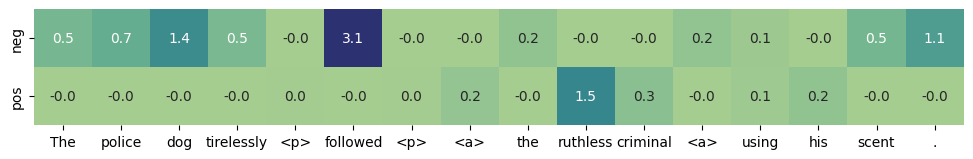

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (12,5))
g = sns.heatmap(instigation_values.T, 
            xticklabels=text, yticklabels=["neg", "pos"],
            square=True, cbar=False, annot=True, fmt=".1f", cmap="crest")
g.tick_params(axis='x', rotation=0)


In [120]:
# text = [t.replace("<a>", "<|arg|>").replace("<p>", "<|pred|>") for t in text]
df = pd.DataFrame(instigation_values.T, columns=text, index=["-INST", "+INST"])
df


,The,police,dog,tirelessly,<p>,followed,<p>,<a>,the,ruthless,criminal,<a>,using,his,scent,.
-INST,0.519291,0.735126,1.402748,0.482112,-0.000000,3.114815,-0.000000,-0.00000,0.222264,-0.000000,-0.000000,0.211433,0.094653,-0.000000,0.547067,1.079703
+INST,-0.000000,-0.000000,-0.000000,-0.000000,0.012798,-0.000000,0.014267,0.19577,-0.000000,1.537782,0.292335,-0.000000,0.077426,0.219043,-0.000000,-0.000000


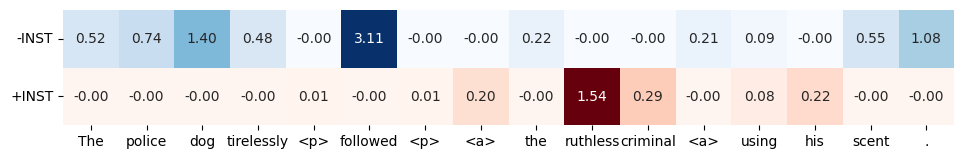

In [121]:
cm = ['Blues', 'Reds', 'Greens', 'Purples']
f, axs = plt.subplots(2, 1, gridspec_kw={'hspace': 0}, figsize=(11.5, 1.5))

counter = 0
for index, row in df.iterrows():
    g = sns.heatmap(np.array([row.values]), yticklabels=[df.index[counter]], xticklabels=df.columns, annot=True, fmt='.2f', ax=axs[counter], cmap=cm[counter], cbar=False)
    counter += 1
    g.tick_params(axis='x', rotation=0)
    g.tick_params(axis='y', rotation=0)

plt.show()


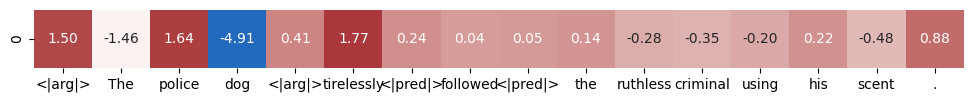

In [81]:
values = instigation_values.T[1] - instigation_values.T[0]

plt.figure(figsize = (12,5))
g = sns.heatmap(values.reshape(1, -1), 
            xticklabels=text, 
            square=True, cbar=False, annot=True, fmt=".2f", cmap="vlag")
g.tick_params(axis='x', rotation=0)
